# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Autoencoders 

In [20]:
# torch modules
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# sklearn and skorch modules
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm
import joblib
import seaborn as sns
sns.set_theme()

# self-made libraries import
from models import StandardAE, DenoisingAE, SupervisedCAE, VariationalAE
from utilities import plot_result, add_noise, MetricsCallback, loss_plot, multiple_plot
from optimization import return_objective 

#LIGHTNING
import pytorch_lightning as pl

# label names for the images
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

## Dataset and Dataloaders

In [11]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)), transforms.ToTensor() ])

# loading train and test dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transforms.ToTensor())
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

# splitting dataset in train and validation
train_split_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[50000,10000])

# transforming datasets
train_split_dataset.transform = transformations

In [14]:
n_cores = torch.get_num_threads()

# defining train and validation dataloaders
train_dataloader = DataLoader(train_split_dataset, batch_size=128, shuffle=True, num_workers=n_cores)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=n_cores)

# defining test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=n_cores)


# Standard autoencoder instantiation

In [ ]:
# creating trainer object for fitting
trainer = pl.Trainer(max_epochs=10,enable_checkpointing=False, callbacks=[MetricsCallback()])

# model instantiation
std_ae = StandardAE({"opt":"Adam","lr":1e-3,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU})

# loading fitted parameters
std_ae.load_state_dict(torch.load("params/autoencoder_weights.pth"))

# # training the model
# trainer.fit(std_ae,train_dataloader, val_dataloader)

In [28]:
# # saving results to files
# torch.save(model.state_dict(), "params/autoencoder_weights.pth")
# torch.save(model.encoder.state_dict(), "params/encoder_weights.pth")

# # saving loss values from callbacks
# np.save("losses/train_loss_std_ae",trainer.callbacks[0].metrics["train_loss"])
# np.save("losses/val_loss_std_ae",trainer.callbacks[0].metrics["val_loss"])

## Autoencoding Test

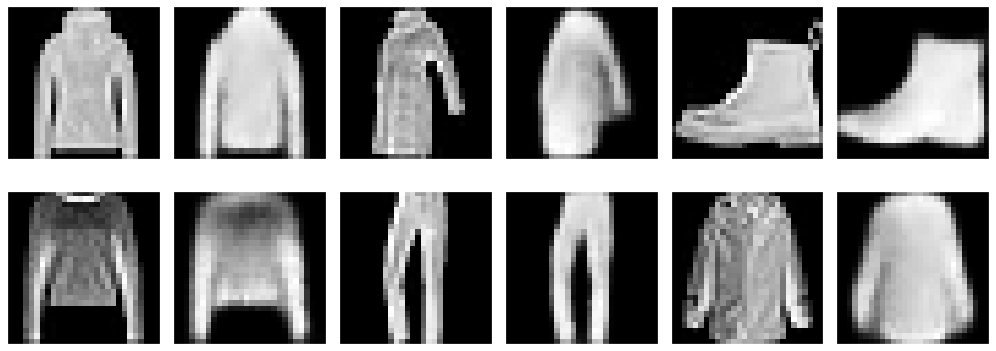

In [43]:
# test the model on some samples of the test dataset

ims = []

for i in range(6):
    im = test_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":im})
    ims.append({"img":std_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/std_ae_test.pdf")

## Network analysis

### Loss plot

In [7]:
train_loss = np.load("losses/train_loss_std_ae.npy")
val_loss = np.load("losses/val_loss_std_ae.npy")

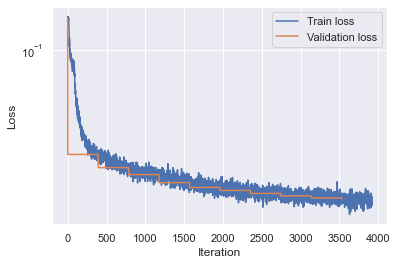

In [8]:
fig, ax = plt.subplots(1,1)
loss_plot(train_loss,val_loss,ax)
plt.savefig("figures/loss_ae.pdf")

### Sample creation

In [34]:
### get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to("cpu")
    label = sample[1]

    # encode image
    std_ae.encoder.eval()
    with torch.no_grad():
        encoded_img  = std_ae.encoder(img)

    # append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# dropping labels
encoded_labels = encoded_samples["label"].copy()
encoded_samples = encoded_samples.drop("label",axis=1)



100%|██████████| 10000/10000 [00:11<00:00, 854.64it/s]


c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\utilities.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


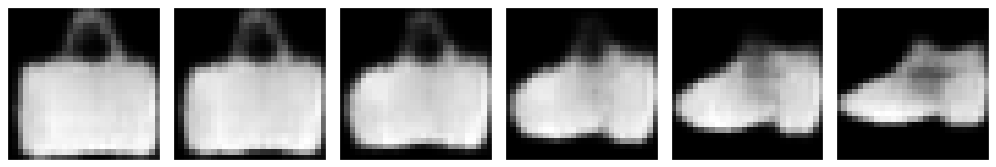

In [37]:
# decoding encoded samples that are produced by mixing encoded representations of different clothes

ims = []
sample1 = torch.tensor(encoded_samples[encoded_labels==9].iloc[1].to_numpy()).float().unsqueeze(0)
sample2 = torch.tensor(encoded_samples[encoded_labels==8].iloc[1].to_numpy()).float().unsqueeze(0)

for i in range(6):
    sample = sample1*i/6 + sample2*(1-i/6)
    ims.append({"img":std_ae.decoder.forward(sample).detach()[0][0]})
    
multiple_plot(plot_result,[1,6], [14,3],ims)

plt.savefig("figures/std_ae_random_samples.pdf")

### TSNE

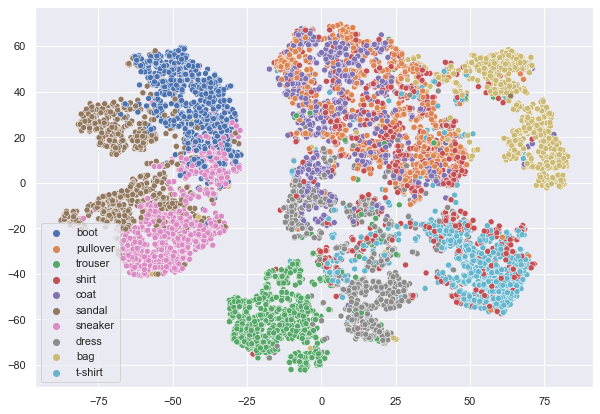

In [38]:
# TSNE encoding of test dataset latent representations

fig, ax = plt.subplots(1,1, figsize=(10,7))
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

g = sns.scatterplot( x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1], hue=[label_names[l] for l in encoded_labels])

plt.savefig("figures/std_ae_tsne.pdf")

### PCA

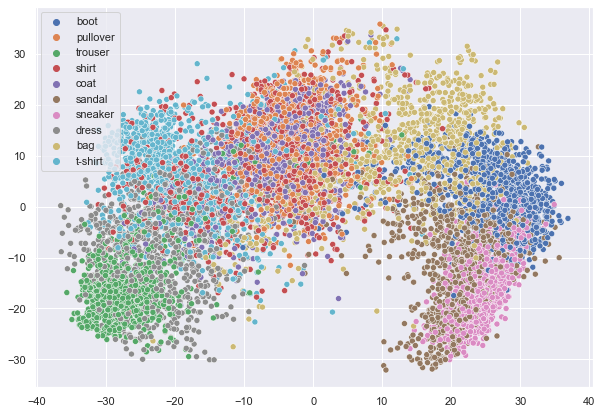

In [39]:
# PCA distribution of test dataset latent representation
fig, ax = plt.subplots(1,1, figsize=(10,7))

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

sns.scatterplot( x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1], hue=[label_names[l] for l in encoded_labels])

plt.savefig("figures/std_ae_pca.pdf")

# Denoising autoencoder

In [40]:
# creating trainer object for fitting
trainer = pl.Trainer(max_epochs=10)

# model instantiation
den_ae = DenoisingAE({"opt":"Adam","lr":4e-3,"reg":3e-5,"encoded_space_dim":30,"in_channels":[50,50,40],"linear_size":70,"act_func":nn.ReLU})

# loading fitted parameters
den_ae.load_state_dict(torch.load("params/denoisingAE_weights.pth"))

# #training the model
# trainer.fit(den_ae,train_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<All keys matched successfully>

In [ ]:
# #saving parameters locally
# torch.save(den_ae.state_dict(), "params/denoisingAE_weights.pth")

## Denoising example

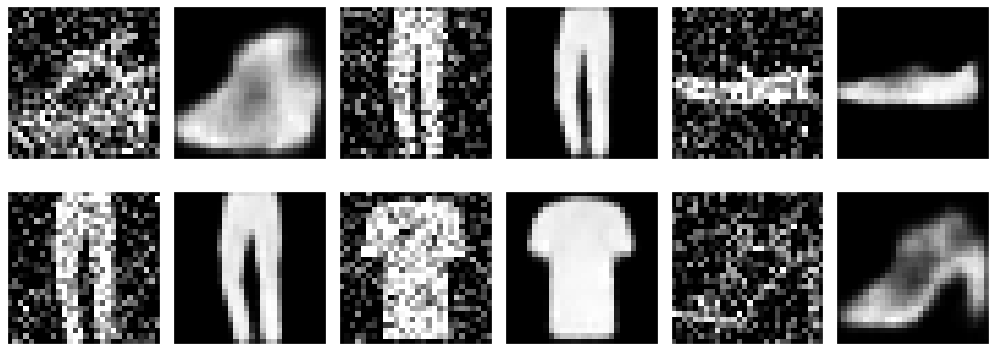

In [45]:
# applying the model on noisy images

ims = []
for i in range(6):
    im = test_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":add_noise(im)})
    ims.append({"img":std_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/den_ae_test.pdf")

# Supervised learning application

In [46]:
# creating trainer object for fitting
trainer = pl.Trainer(max_epochs=10)

# model instantiation
supervised_ae = SupervisedCAE({"opt":"Adam","lr":1e-4,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU, "out_linear_size":200},PATH="params/encoder_weights.pth")

# loading fitted parameters
supervised_ae.load_state_dict(torch.load("params/supervisedCAE_weights.pth"))

# #training the model
# trainer.fit(supervised_ae,train_dataloader, val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<All keys matched successfully>

In [ ]:
# #saving parameters locally
# torch.save(supervised_ae.state_dict(), "params/supervisedCAE_weights.pth")

## Confusion matrix

In [47]:
# predicted label creation

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = supervised_ae.forward(inputs) # feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # save prediction values
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # save true values

C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


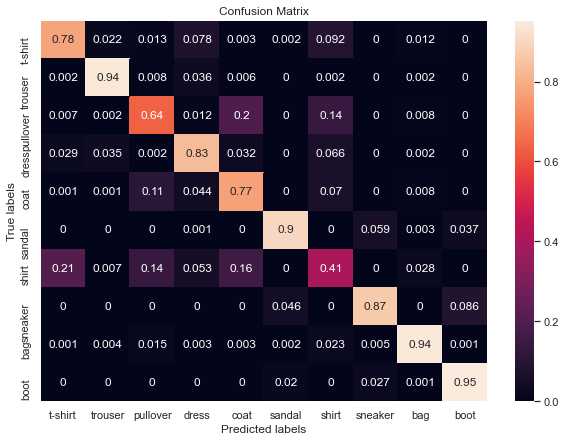

In [48]:
# plotting the confusion matrix for the prediction
fig, ax = plt.subplots(figsize = (10,7))
c_matrix = confusion_matrix(y_true,y_pred)
sns.heatmap(c_matrix/c_matrix.astype(float).sum(axis=1) ,annot=True)

ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.savefig("figures/conf_matrix.pdf")

In [49]:
# single class accuracies
print("Accuracies for the 10 classes: ", c_matrix.diagonal()/c_matrix.sum(axis=1))
# total accuracy
print(f"Total accuracy: {(c_matrix.diagonal()/c_matrix.sum(axis=1)).mean():.2f}")

Accuracies for the 10 classes:  [0.778 0.944 0.638 0.834 0.77  0.9   0.405 0.868 0.943 0.952]
Total accuracy: 0.80


# Variational Autoencoder

In [50]:
# creating trainer object for fitting
# trainer = pl.Trainer(max_epochs=10)

# model instantiation
var_ae = VariationalAE(hyper={"opt":"Adam","lr":1e-2,"reg":0,"encoded_space_dim":40,"in_channels":[16,32,64],"linear_size":100,"act_func":nn.ReLU, "out_linear_size":100})

# loading fitted parameters
var_ae.load_state_dict(torch.load("params/variationalAE_weights.pth"))

# #training the model
# trainer.fit(var_ae,train_dataloader)

<All keys matched successfully>

In [ ]:
# #saving parameters locally
# torch.save(var_ae.state_dict(), "params/variationalAE_weights.pth")

## Autoencoding test

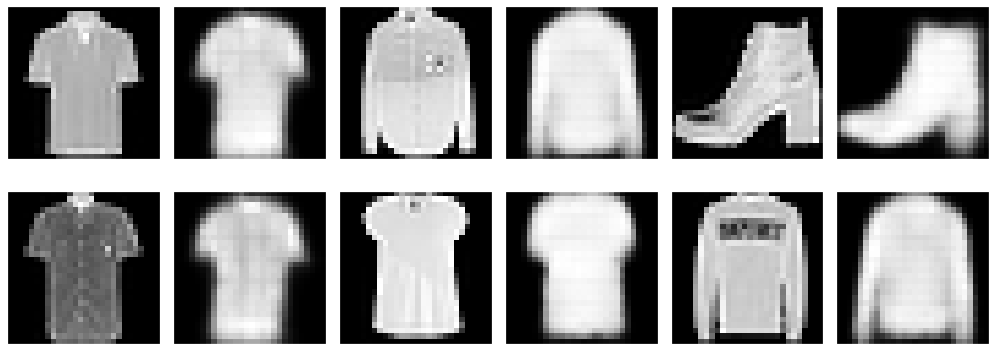

In [79]:
# testing the autoencoder on some images
ims = []

for i in range(6):
    im = test_dataset[np.random.randint(1,10000)][0][0]
    ims.append({"img":im})
    ims.append({"img":var_ae.forward(im.reshape([1,1,28,28])).detach()[0][0]})
    
multiple_plot(plot_result,[2,6], [14,7],ims)

plt.savefig("figures/vae_ae_test.pdf")

## TSNE and PCA plot

In [62]:
### Get the encoded representation for the means of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to("cpu")
    label = sample[1]
    # Encode image
    var_ae.encoder.eval()
    var_ae.linear2.eval()
    with torch.no_grad():
        encoded_img  = var_ae.encoder(img)
        encoded_img  = var_ae.linear2(encoded_img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# dropping labels
encoded_labels = encoded_samples["label"].copy()
encoded_samples = encoded_samples.drop("label",axis=1)



100%|██████████| 10000/10000 [00:13<00:00, 764.70it/s]


<Figure size 432x288 with 0 Axes>

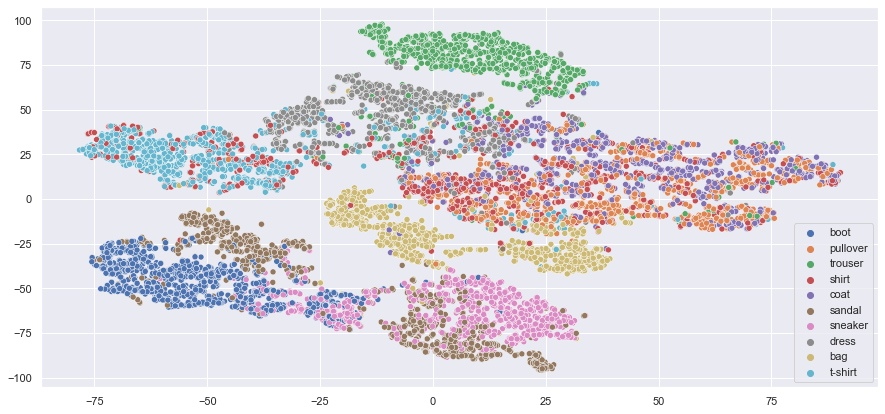

In [63]:
# plotting TSNE distribution of latent space samples

tsne = TSNE(n_components=2)
plt.tight_layout()
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

fig, ax = plt.subplots(1,1, figsize=(15,7))
g = sns.scatterplot( x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1], hue=[label_names[l] for l in encoded_labels])
plt.savefig("figures/vae_tsne.pdf")

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

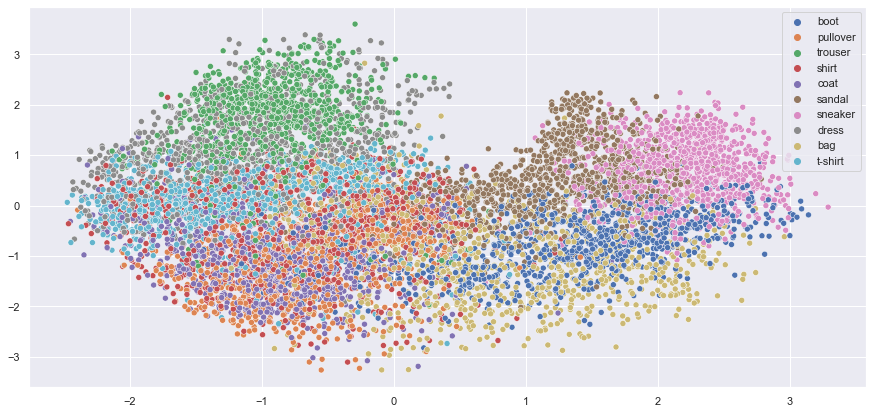

In [64]:
# plotting PCA distribution of encoded variables

pca = PCA(n_components=2)

plt.tight_layout()
fig, ax = plt.subplots(1,1, figsize=(15,7))

encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

sns.scatterplot( x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1], hue=[label_names[l] for l in encoded_labels])


# Optuna optimization tests

In [ ]:
# objective = return_objective(StandardAE,train_dataset,10,device="cpu")
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=70)
study = joblib.load("studies/study.pkl")
# joblib.dump(study,"study.pkl")


In [ ]:
# objective_den = return_objective(DenoisingAE,train_dataset,10)

# study_den = optuna.create_study(direction='minimize')
# study_den.optimize(objective_den, n_trials=70)
study = joblib.load("studies/study_den.pkl")
# joblib.dump(study_den,"study_den.pkl")


In [ ]:
# objective_vae = return_objective(VariationalAE,train_dataset,10)

# study_vae = optuna.create_study(direction='minimize')
# study_vae.optimize(objective_vae, n_trials=70)
study = joblib.load("studies/study_vae.pkl")
# joblib.dump(study_vae,"study_vae.pkl")